In [34]:
# ============================================
# Kaggle: Make Data Count - Finding Data References
# Models: SVM + Decision Tree
# Output: submission.csv + .pkl models
# ============================================

# ---- 0) Imports & Setup
import os, re, gc, json, pickle, joblib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from scipy import sparse
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

BASE = Path("/kaggle/input/make-data-count-finding-data-references")
TRAIN_XML = BASE / "train/XML"
TEST_XML  = BASE / "test/XML"
TRAIN_LABELS = BASE / "train_labels.csv"
SAMPLE_SUB = BASE / "sample_submission.csv"

assert TRAIN_XML.exists() and TEST_XML.exists(), "XML folders not found"
assert Path(TRAIN_LABELS).exists(), "train_labels.csv not found"
assert Path(SAMPLE_SUB).exists(), "sample_submission.csv not found"

# ---- 1) Data loading
train_labels = pd.read_csv(TRAIN_LABELS)
sample_sub   = pd.read_csv(SAMPLE_SUB)

# Map labels ↔ ids
lab2id = {"Primary":0, "Secondary":1, "Missing":2}
id2lab = {v:k for k,v in lab2id.items()}

# ---- 2) Robust XML → text
def xml2txt(p: Path) -> str:
    """Extract visible text using itertext(); collapse whitespace; handle parse errors."""
    try:
        root = ET.parse(p).getroot()
        # itertext() walks entire tree (sections, paragraphs, inline)
        text = " ".join(t for t in root.itertext())
        text = re.sub(r"\s+", " ", text).strip()
        return text
    except Exception:
        return ""

# Normalization so join with CSV stays consistent
def normalize_id(s: str) -> str:
    # filenames look like '10.1002_ece3.5260' (slashes became underscores)
    return s.replace("/", "_")

# ---- 3) Parse train/test XML
print("Parsing train XML ...")
train_text = {}
for f in tqdm(list(TRAIN_XML.glob("*.xml"))):
    train_text[normalize_id(f.stem)] = xml2txt(f)

print("Parsing test XML ...")
test_text = {}
for f in tqdm(list(TEST_XML.glob("*.xml"))):
    test_text[normalize_id(f.stem)] = xml2txt(f)

# Add normalized ids to labels/sub for safe joins
train_labels["article_id"] = train_labels["article_id"].apply(normalize_id)
sample_sub["article_id"]   = sample_sub["article_id"].apply(normalize_id)

train = train_labels.assign(text=lambda d: d.article_id.map(train_text)).dropna(subset=["text"])
test  = sample_sub.assign(text=lambda d: d.article_id.map(test_text)).fillna({"text": ""})

# Ensure text present
train = train[train.text.str.len() > 0].reset_index(drop=True)
print(f"Train rows with text: {len(train)}")
print(f"Test rows with text:  {len(test)}")

# Labels
train["y"] = train["type"].map(lab2id).astype(int)

# ---- 4) Split for validation (stratified)
trn, val = train_test_split(
    train[["article_id", "dataset_id", "text", "y"]],
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=train["y"]
)

# ---- 5) Feature extractor (word+char TF-IDF)
word_tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=2,
    max_features=120_000,
    stop_words="english",
    sublinear_tf=True
)
char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=2,
    max_features=150_000,
    sublinear_tf=True
)

# We use ColumnTransformer with a "text" field
preprocess = ColumnTransformer(
    transformers=[
        ("w", word_tfidf, "text"),
        ("c", char_tfidf, "text"),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ---- 6A) Model 1: Linear SVM (strong baseline for text)
svm_clf = LinearSVC(
    C=1.0,
    class_weight="balanced",  # handles class imbalance
    random_state=RANDOM_STATE
)
svm_pipe = Pipeline([
    ("tfidf", preprocess),
    ("clf", svm_clf)
])

print("\nTraining SVM ...")
svm_pipe.fit(trn, trn["y"])

# Evaluate
val_pred_svm = svm_pipe.predict(val)
svm_f1 = f1_score(val["y"], val_pred_svm, average="macro")
print(f"SVM Macro-F1 (val): {svm_f1:.4f}")
print("SVM classification report:\n", classification_report(val["y"], val_pred_svm, target_names=list(lab2id.keys())))

# ---- 6B) Model 2: Decision Tree
# Trees struggle with super-sparse high-dim features, so reduce dimension first.
# TruncatedSVD works directly on sparse TF-IDF matrices.
svd = TruncatedSVD(n_components=256, random_state=RANDOM_STATE)
scaler = StandardScaler(with_mean=False)  # keep sparse compatibility (after SVD it's dense; with_mean=False safe)

dt_clf = DecisionTreeClassifier(
    max_depth=40,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

dt_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", svd),
    ("scale", scaler),
    ("clf", dt_clf)
])

print("\nTraining Decision Tree ...")
dt_pipe.fit(trn, trn["y"])

# Evaluate
val_pred_dt = dt_pipe.predict(val)
dt_f1 = f1_score(val["y"], val_pred_dt, average="macro")
print(f"Decision Tree Macro-F1 (val): {dt_f1:.4f}")
print("Decision Tree classification report:\n", classification_report(val["y"], val_pred_dt, target_names=list(lab2id.keys())))

# ---- 7) Pick best model by macro-F1 and generate predictions for test
best_pipe, best_name, best_f1 = (svm_pipe, "SVM", svm_f1) if svm_f1 >= dt_f1 else (dt_pipe, "DecisionTree", dt_f1)
print(f"\nSelected model for submission: {best_name} (val Macro-F1={best_f1:.4f})")

test_pred = best_pipe.predict(test)
test_labels = [ {v:k for k,v in lab2id.items()}[int(i)] for i in test_pred ]

submission = test.copy()
submission["type"] = test_labels
submission[["article_id", "dataset_id", "type"]].to_csv("/kaggle/working/submission.csv", index=False)
print("\n✅ Saved /kaggle/working/submission.csv with", len(submission), "rows")

# ---- 8) Save both trained pipelines as .pkl (self-contained)
joblib.dump(svm_pipe, "/kaggle/working/svm_model.pkl")
joblib.dump(dt_pipe,  "/kaggle/working/decision_tree_model.pkl")
print("✅ Saved models: svm_model.pkl, decision_tree_model.pkl")

# ---- 9) Quick sanity prints
print("\nSample predictions (first 10):")
print(submission[["article_id", "dataset_id", "type"]].head(10))


Parsing train XML ...


100%|██████████| 400/400 [00:04<00:00, 97.44it/s] 


Parsing test XML ...


100%|██████████| 25/25 [00:00<00:00, 124.50it/s]


Train rows with text: 902
Test rows with text:  14

Training SVM ...
SVM Macro-F1 (val): 0.9413
SVM classification report:
               precision    recall  f1-score   support

     Primary       0.85      0.93      0.89        44
   Secondary       0.98      0.93      0.95        85
     Missing       0.98      0.98      0.98        52

    accuracy                           0.94       181
   macro avg       0.94      0.95      0.94       181
weighted avg       0.95      0.94      0.95       181


Training Decision Tree ...
Decision Tree Macro-F1 (val): 0.9141
Decision Tree classification report:
               precision    recall  f1-score   support

     Primary       0.83      0.89      0.86        44
   Secondary       0.98      0.93      0.95        85
     Missing       0.92      0.94      0.93        52

    accuracy                           0.92       181
   macro avg       0.91      0.92      0.91       181
weighted avg       0.93      0.92      0.92       181


Selected m

Parsing train XML ...


100%|██████████| 400/400 [00:04<00:00, 99.56it/s] 


Parsing test XML ...


100%|██████████| 25/25 [00:00<00:00, 113.73it/s]


Train rows: 902 | Test rows: 14
Class counts: {0: 222, 1: 423, 2: 257}

=== Support Vector Machine (LinearSVC) ===
Macro-F1 (val): 0.9413
              precision    recall  f1-score   support

     Primary       0.85      0.93      0.89        44
   Secondary       0.98      0.93      0.95        85
     Missing       0.98      0.98      0.98        52

    accuracy                           0.94       181
   macro avg       0.94      0.95      0.94       181
weighted avg       0.95      0.94      0.95       181



<Figure size 450x400 with 0 Axes>

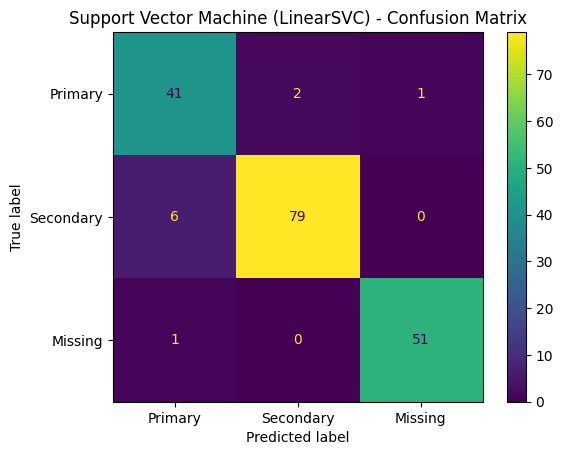


=== Neural Network (MLP) ===
Macro-F1 (val): 0.8708
              precision    recall  f1-score   support

     Primary       0.78      0.80      0.79        44
   Secondary       0.92      0.93      0.92        85
     Missing       0.92      0.88      0.90        52

    accuracy                           0.88       181
   macro avg       0.87      0.87      0.87       181
weighted avg       0.88      0.88      0.88       181



<Figure size 450x400 with 0 Axes>

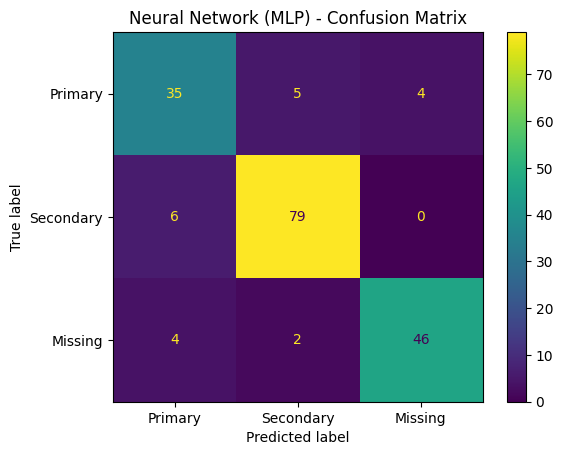


=== Decision Tree ===
Macro-F1 (val): 0.9141
              precision    recall  f1-score   support

     Primary       0.83      0.89      0.86        44
   Secondary       0.98      0.93      0.95        85
     Missing       0.92      0.94      0.93        52

    accuracy                           0.92       181
   macro avg       0.91      0.92      0.91       181
weighted avg       0.93      0.92      0.92       181



<Figure size 450x400 with 0 Axes>

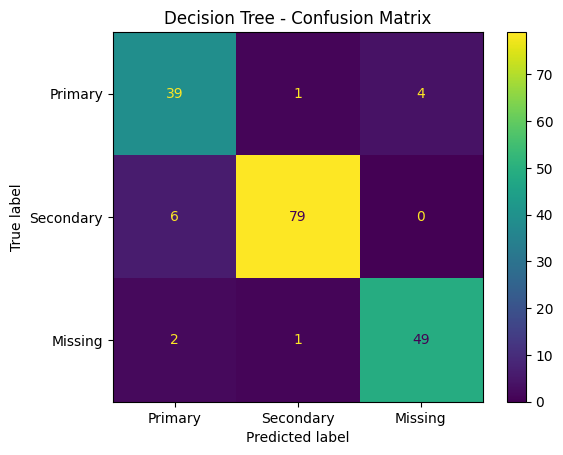


=== Random Forest ===
Macro-F1 (val): 0.9341
              precision    recall  f1-score   support

     Primary       0.85      0.91      0.88        44
   Secondary       0.98      0.93      0.95        85
     Missing       0.96      0.98      0.97        52

    accuracy                           0.94       181
   macro avg       0.93      0.94      0.93       181
weighted avg       0.94      0.94      0.94       181



<Figure size 450x400 with 0 Axes>

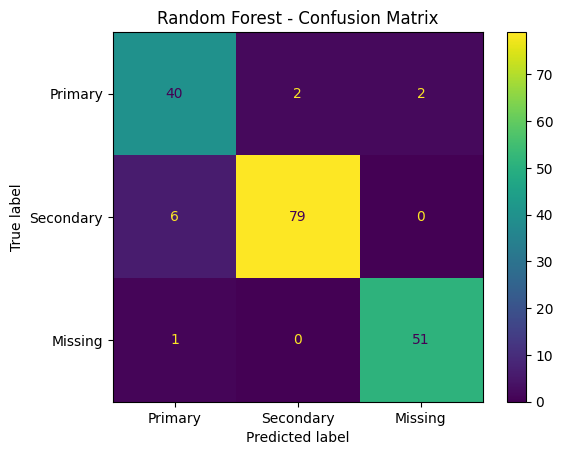


=== Clustering (KMeans) on validation ===
Cluster→Label accuracy (Hungarian): 0.3978
Homogeneity: 0.0788 | Completeness: 0.1596 | V-measure: 0.1055 | ARI: -0.0225
Cluster→Label mapping: {np.int64(2): np.int64(0), np.int64(1): np.int64(1), np.int64(0): np.int64(2)}


<Figure size 450x400 with 0 Axes>

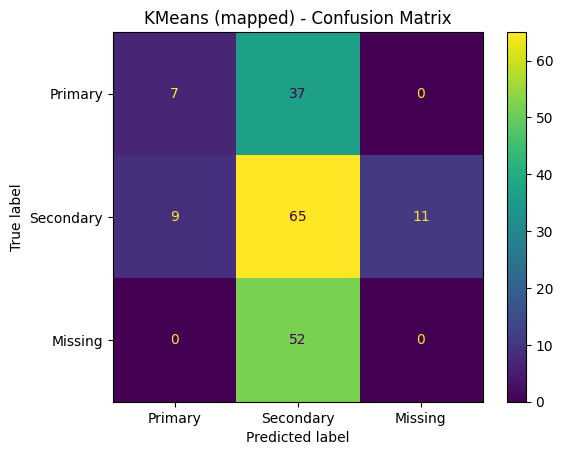


Best supervised model on validation: SVM (Macro-F1=0.9413)
✅ Saved /kaggle/working/submission.csv

=== Summary (Validation Macro-F1) ===
          Model  MacroF1_Val
0           SVM     0.941294
1  RandomForest     0.934119
2  DecisionTree     0.914094
3           MLP     0.870818


In [35]:
# ============================================================
# Kaggle: Make Data Count - Finding Data References (Analysis)
# Methods: SVM, MLP, Decision Tree, KMeans, Random Forest
# NOTE: No .pkl files are created.
# ============================================================

# ---- 0) Imports & setup
import os, re, gc, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---- 1) Paths
BASE = Path("/kaggle/input/make-data-count-finding-data-references")
TRAIN_XML = BASE / "train/XML"
TEST_XML  = BASE / "test/XML"
TRAIN_LABELS = BASE / "train_labels.csv"
SAMPLE_SUB   = BASE / "sample_submission.csv"

assert TRAIN_XML.exists() and TEST_XML.exists(), "XML folders not found"
assert TRAIN_LABELS.exists(), "train_labels.csv not found"
assert SAMPLE_SUB.exists(), "sample_submission.csv not found"

# ---- 2) Load labels & helper maps
train_labels = pd.read_csv(TRAIN_LABELS)
sample_sub   = pd.read_csv(SAMPLE_SUB)
lab2id = {"Primary":0, "Secondary":1, "Missing":2}
id2lab = {v:k for k,v in lab2id.items()}

def normalize_id(s: str) -> str:
    # filenames use underscores where article_id may have slashes
    return s.replace("/", "_")

train_labels["article_id"] = train_labels["article_id"].apply(normalize_id)
sample_sub["article_id"]   = sample_sub["article_id"].apply(normalize_id)

# ---- 3) XML → text (robust)
def xml2txt(p: Path) -> str:
    try:
        root = ET.parse(p).getroot()
        text = " ".join(root.itertext())
        return re.sub(r"\s+", " ", text).strip()
    except Exception:
        return ""

print("Parsing train XML ...")
train_text = {f.stem: xml2txt(f) for f in tqdm(list(TRAIN_XML.glob("*.xml")))}

print("Parsing test XML ...")
test_text  = {f.stem: xml2txt(f) for f in tqdm(list(TEST_XML.glob("*.xml")))}

# ---- 4) Build train/test frames
train = train_labels.assign(text=lambda d: d.article_id.map(train_text))
train = train[train["text"].fillna("").str.len() > 0].reset_index(drop=True)
train["y"] = train["type"].map(lab2id).astype(int)

test  = sample_sub.assign(text=lambda d: d.article_id.map(test_text)).fillna({"text": ""})

print(f"Train rows: {len(train)} | Test rows: {len(test)}")
print("Class counts:", train["y"].value_counts().sort_index().to_dict())

# ---- 5) Train/validation split
trn, val = train_test_split(
    train[["article_id","dataset_id","text","y"]],
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=train["y"]
)

# ---- 6) Text features (word + char TF-IDF)
word_tfidf = TfidfVectorizer(
    analyzer="word", ngram_range=(1,2),
    min_df=2, max_features=120_000,
    stop_words="english", sublinear_tf=True
)
char_tfidf = TfidfVectorizer(
    analyzer="char", ngram_range=(3,5),
    min_df=2, max_features=150_000,
    sublinear_tf=True
)

preprocess = ColumnTransformer(
    [("w", word_tfidf, "text"),
     ("c", char_tfidf, "text")],
    remainder="drop", verbose_feature_names_out=False
)

# Utility: fit/eval supervised model
def train_eval(model_name, model_pipeline):
    model_pipeline.fit(trn, trn["y"])
    pred = model_pipeline.predict(val)
    f1 = f1_score(val["y"], pred, average="macro")
    print(f"\n=== {model_name} ===")
    print(f"Macro-F1 (val): {f1:.4f}")
    print(classification_report(val["y"], pred, target_names=list(lab2id.keys())))
    # Confusion matrix
    cm = confusion_matrix(val["y"], pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(cm, display_labels=[id2lab[i] for i in [0,1,2]])
    plt.figure(figsize=(4.5,4))
    disp.plot(values_format='d')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()
    return f1, model_pipeline

results = {}

# ---- 7A) Support Vector Machines (Linear SVM)
svm_pipe = Pipeline([
    ("tfidf", preprocess),
    ("clf", LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM_STATE))
])
f1_svm, pipe_svm = train_eval("Support Vector Machine (LinearSVC)", svm_pipe)
results["SVM"] = (f1_svm, pipe_svm)

# ---- 7B) Neural Networks (MLPClassifier)
# Reduce dimensionality first (TruncatedSVD) then MLP
mlp_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE)),
    ("scale", StandardScaler(with_mean=True)),
    ("clf", MLPClassifier(hidden_layer_sizes=(256,),
                          activation="relu", solver="adam",
                          alpha=1e-4, batch_size=256, max_iter=15,
                          random_state=RANDOM_STATE, early_stopping=True))
])
f1_mlp, pipe_mlp = train_eval("Neural Network (MLP)", mlp_pipe)
results["MLP"] = (f1_mlp, pipe_mlp)

# ---- 7C) Decision Trees (with SVD)
dt_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE)),
    ("scale", StandardScaler(with_mean=True)),
    ("clf", DecisionTreeClassifier(max_depth=40,
                                   min_samples_split=5,
                                   min_samples_leaf=2,
                                   class_weight="balanced",
                                   random_state=RANDOM_STATE))
])
f1_dt, pipe_dt = train_eval("Decision Tree", dt_pipe)
results["DecisionTree"] = (f1_dt, pipe_dt)

# ---- 7D) Ensemble: Random Forests (with SVD)
rf_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE)),
    # no scaler needed for RF
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        class_weight="balanced_subsample", n_jobs=-1, random_state=RANDOM_STATE
    ))
])
f1_rf, pipe_rf = train_eval("Random Forest", rf_pipe)
results["RandomForest"] = (f1_rf, pipe_rf)

# ---- 8) Unsupervised: Clustering (KMeans on SVD of TF-IDF)
# Evaluate with V-measure, Homogeneity, Completeness, Adjusted Rand Index (against ground truth)
kmeans_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE))
])
X_val_red = kmeans_pipe.fit_transform(val)  # fit on val text only to avoid leakage from train
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=20)
clusters = kmeans.fit_predict(X_val_red)

# Map clusters → true labels for an accuracy-like view using Hungarian assignment
def cluster_to_label_accuracy(y_true, y_pred, n_classes=3):
    cost = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(n_classes):
        for j in range(n_classes):
            cost[i, j] = np.sum((y_true == i) & (y_pred == j)) * -1  # negative for maximization
    row_ind, col_ind = linear_sum_assignment(cost)
    mapping = {cluster: label for cluster, label in zip(col_ind, row_ind)}
    mapped = np.vectorize(mapping.get)(y_pred)
    acc = (mapped == y_true).mean()
    return acc, mapping, mapped

km_acc, km_map, km_pred_mapped = cluster_to_label_accuracy(val["y"].values, clusters, n_classes=3)
hom = homogeneity_score(val["y"], clusters)
com = completeness_score(val["y"], clusters)
vms = v_measure_score(val["y"], clusters)
ari = adjusted_rand_score(val["y"], clusters)

print("\n=== Clustering (KMeans) on validation ===")
print(f"Cluster→Label accuracy (Hungarian): {km_acc:.4f}")
print(f"Homogeneity: {hom:.4f} | Completeness: {com:.4f} | V-measure: {vms:.4f} | ARI: {ari:.4f}")
print("Cluster→Label mapping:", km_map)

cm = confusion_matrix(val["y"], km_pred_mapped, labels=[0,1,2])
disp = ConfusionMatrixDisplay(cm, display_labels=[id2lab[i] for i in [0,1,2]])
plt.figure(figsize=(4.5,4))
disp.plot(values_format='d')
plt.title("KMeans (mapped) - Confusion Matrix")
plt.show()

# ---- 9) Pick best supervised model for (optional) submission
best_name, (best_f1, best_pipe) = max(results.items(), key=lambda kv: kv[1][0])
print(f"\nBest supervised model on validation: {best_name} (Macro-F1={best_f1:.4f})")

MAKE_SUBMISSION = True  # set False if you don't want to write submission
if MAKE_SUBMISSION:
    test_pred = best_pipe.predict(test)
    test_labels = [id2lab[int(i)] for i in test_pred]
    sub = test.copy()
    sub["type"] = test_labels
    sub[["article_id","dataset_id","type"]].to_csv("/kaggle/working/submission.csv", index=False)
    print("✅ Saved /kaggle/working/submission.csv")

# ---- 10) Quick summary table
summary = (
    pd.DataFrame({
        "Model": list(results.keys()),
        "MacroF1_Val": [v[0] for v in results.values()]
    })
    .sort_values("MacroF1_Val", ascending=False)
    .reset_index(drop=True)
)
print("\n=== Summary (Validation Macro-F1) ===")
print(summary)



Parsing train XML ...


100%|██████████| 400/400 [00:04<00:00, 87.78it/s] 


Parsing test XML ...


100%|██████████| 25/25 [00:00<00:00, 110.70it/s]


Train rows: 902 | Test rows: 14
Class counts: {0: 222, 1: 423, 2: 257}

=== Support Vector Machine (LinearSVC) ===
Accuracy (val): 0.9448 | Macro-F1 (val): 0.9413
              precision    recall  f1-score   support

     Primary       0.85      0.93      0.89        44
   Secondary       0.98      0.93      0.95        85
     Missing       0.98      0.98      0.98        52

    accuracy                           0.94       181
   macro avg       0.94      0.95      0.94       181
weighted avg       0.95      0.94      0.95       181



<Figure size 450x400 with 0 Axes>

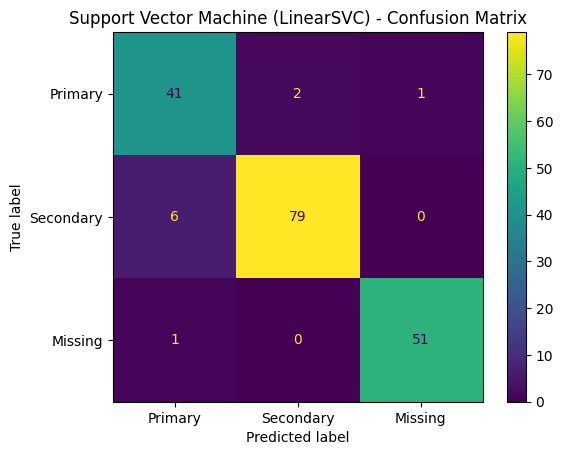


=== Neural Network (MLP) ===
Accuracy (val): 0.8840 | Macro-F1 (val): 0.8708
              precision    recall  f1-score   support

     Primary       0.78      0.80      0.79        44
   Secondary       0.92      0.93      0.92        85
     Missing       0.92      0.88      0.90        52

    accuracy                           0.88       181
   macro avg       0.87      0.87      0.87       181
weighted avg       0.88      0.88      0.88       181



<Figure size 450x400 with 0 Axes>

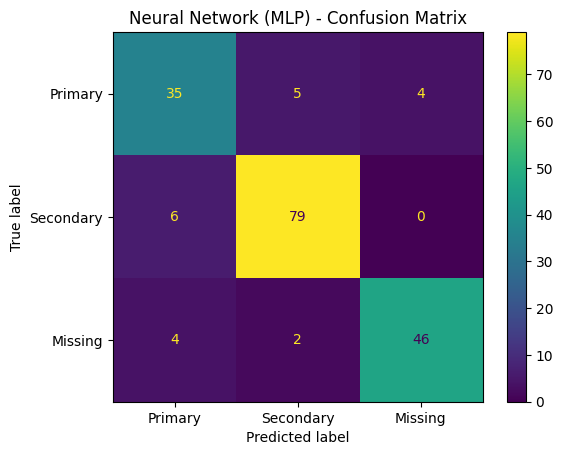


=== Decision Tree ===
Accuracy (val): 0.9227 | Macro-F1 (val): 0.9141
              precision    recall  f1-score   support

     Primary       0.83      0.89      0.86        44
   Secondary       0.98      0.93      0.95        85
     Missing       0.92      0.94      0.93        52

    accuracy                           0.92       181
   macro avg       0.91      0.92      0.91       181
weighted avg       0.93      0.92      0.92       181



<Figure size 450x400 with 0 Axes>

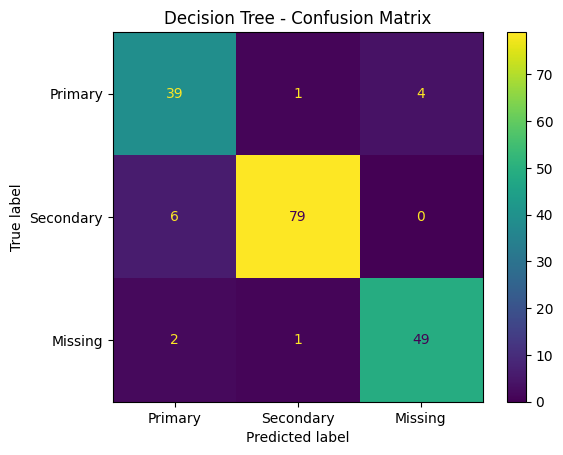


=== Random Forest ===
Accuracy (val): 0.9392 | Macro-F1 (val): 0.9341
              precision    recall  f1-score   support

     Primary       0.85      0.91      0.88        44
   Secondary       0.98      0.93      0.95        85
     Missing       0.96      0.98      0.97        52

    accuracy                           0.94       181
   macro avg       0.93      0.94      0.93       181
weighted avg       0.94      0.94      0.94       181



<Figure size 450x400 with 0 Axes>

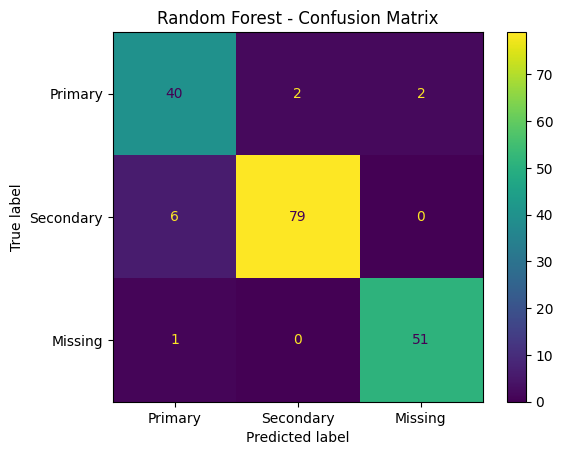


=== Clustering (KMeans) on validation ===
Cluster→Label accuracy (Hungarian): 0.3978
Homogeneity: 0.0788 | Completeness: 0.1596 | V-measure: 0.1055 | ARI: -0.0225
Cluster→Label mapping: {np.int64(2): np.int64(0), np.int64(1): np.int64(1), np.int64(0): np.int64(2)}


<Figure size 450x400 with 0 Axes>

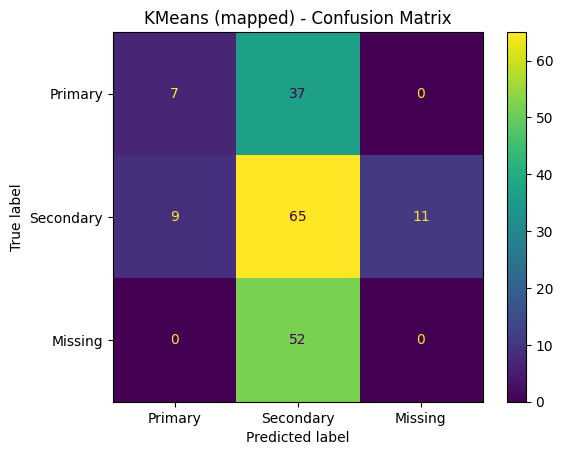


🏆 Highest validation ACCURACY: SVM | Acc=0.9448 | Macro-F1=0.9413
✅ Saved best supervised model to: /kaggle/working/best_model.pkl
✅ Saved /kaggle/working/submission.csv

=== Summary (Validation Metrics) ===
          Model  Val_Accuracy  Val_MacroF1
0           SVM      0.944751     0.941294
1  RandomForest      0.939227     0.934119
2  DecisionTree      0.922652     0.914094
3           MLP      0.883978     0.870818


In [36]:
# ============================================================
# Kaggle: Make Data Count - Finding Data References (Analysis)
# Methods: SVM, MLP, Decision Tree, KMeans, Random Forest
# NOTE: Creates a .pkl ONLY for the highest-accuracy SUPERVISED model.
# ============================================================

# ---- 0) Imports & setup
import os, re, gc, warnings, joblib
from pathlib import Path
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---- 1) Paths
BASE = Path("/kaggle/input/make-data-count-finding-data-references")
TRAIN_XML = BASE / "train/XML"
TEST_XML  = BASE / "test/XML"
TRAIN_LABELS = BASE / "train_labels.csv"
SAMPLE_SUB   = BASE / "sample_submission.csv"

assert TRAIN_XML.exists() and TEST_XML.exists(), "XML folders not found"
assert TRAIN_LABELS.exists(), "train_labels.csv not found"
assert SAMPLE_SUB.exists(), "sample_submission.csv not found"

# ---- 2) Load labels & helper maps
train_labels = pd.read_csv(TRAIN_LABELS)
sample_sub   = pd.read_csv(SAMPLE_SUB)
lab2id = {"Primary":0, "Secondary":1, "Missing":2}
id2lab = {v:k for k,v in lab2id.items()}

def normalize_id(s: str) -> str:
    return s.replace("/", "_")

train_labels["article_id"] = train_labels["article_id"].apply(normalize_id)
sample_sub["article_id"]   = sample_sub["article_id"].apply(normalize_id)

# ---- 3) XML → text (robust)
def xml2txt(p: Path) -> str:
    try:
        root = ET.parse(p).getroot()
        text = " ".join(root.itertext())
        return re.sub(r"\s+", " ", text).strip()
    except Exception:
        return ""

print("Parsing train XML ...")
train_text = {f.stem: xml2txt(f) for f in tqdm(list(TRAIN_XML.glob("*.xml")))}

print("Parsing test XML ...")
test_text  = {f.stem: xml2txt(f) for f in tqdm(list(TEST_XML.glob("*.xml")))}

# ---- 4) Build train/test frames
train = train_labels.assign(text=lambda d: d.article_id.map(train_text))
train = train[train["text"].fillna("").str.len() > 0].reset_index(drop=True)
train["y"] = train["type"].map(lab2id).astype(int)

test  = sample_sub.assign(text=lambda d: d.article_id.map(test_text)).fillna({"text": ""})

print(f"Train rows: {len(train)} | Test rows: {len(test)}")
print("Class counts:", train["y"].value_counts().sort_index().to_dict())

# ---- 5) Train/validation split
trn, val = train_test_split(
    train[["article_id","dataset_id","text","y"]],
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=train["y"]
)

# ---- 6) Text features (word + char TF-IDF)
word_tfidf = TfidfVectorizer(
    analyzer="word", ngram_range=(1,2),
    min_df=2, max_features=120_000,
    stop_words="english", sublinear_tf=True
)
char_tfidf = TfidfVectorizer(
    analyzer="char", ngram_range=(3,5),
    min_df=2, max_features=150_000,
    sublinear_tf=True
)

preprocess = ColumnTransformer(
    [("w", word_tfidf, "text"),
     ("c", char_tfidf, "text")],
    remainder="drop", verbose_feature_names_out=False
)

# ---- Utility: supervised train/eval
def train_eval_supervised(model_name, model_pipeline):
    model_pipeline.fit(trn, trn["y"])
    pred = model_pipeline.predict(val)
    acc = accuracy_score(val["y"], pred)
    f1  = f1_score(val["y"], pred, average="macro")
    print(f"\n=== {model_name} ===")
    print(f"Accuracy (val): {acc:.4f} | Macro-F1 (val): {f1:.4f}")
    print(classification_report(val["y"], pred, target_names=list(lab2id.keys())))
    # Confusion matrix
    cm = confusion_matrix(val["y"], pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(cm, display_labels=[id2lab[i] for i in [0,1,2]])
    plt.figure(figsize=(4.5,4))
    disp.plot(values_format='d')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()
    return {"acc": acc, "f1": f1, "pipe": model_pipeline}

results = {}

# ---- 7A) Support Vector Machines (Linear SVM)
svm_pipe = Pipeline([
    ("tfidf", preprocess),
    ("clf", LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM_STATE))
])
results["SVM"] = train_eval_supervised("Support Vector Machine (LinearSVC)", svm_pipe)

# ---- 7B) Neural Networks (MLPClassifier) with SVD reduction
mlp_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE)),
    ("scale", StandardScaler(with_mean=True)),
    ("clf", MLPClassifier(hidden_layer_sizes=(256,),
                          activation="relu", solver="adam",
                          alpha=1e-4, batch_size=256, max_iter=15,
                          random_state=RANDOM_STATE, early_stopping=True))
])
results["MLP"] = train_eval_supervised("Neural Network (MLP)", mlp_pipe)

# ---- 7C) Decision Trees (with SVD)
dt_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE)),
    ("scale", StandardScaler(with_mean=True)),
    ("clf", DecisionTreeClassifier(max_depth=40,
                                   min_samples_split=5,
                                   min_samples_leaf=2,
                                   class_weight="balanced",
                                   random_state=RANDOM_STATE))
])
results["DecisionTree"] = train_eval_supervised("Decision Tree", dt_pipe)

# ---- 7D) Ensemble: Random Forests (with SVD)
rf_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE)),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        class_weight="balanced_subsample", n_jobs=-1, random_state=RANDOM_STATE
    ))
])
results["RandomForest"] = train_eval_supervised("Random Forest", rf_pipe)

# ---- 8) Unsupervised: Clustering (KMeans) - reported, not saved
from sklearn.cluster import KMeans
kmeans_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE))
])
X_val_red = kmeans_pipe.fit_transform(val)  # fit on val text only to avoid leakage
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=20)
clusters = kmeans.fit_predict(X_val_red)

def cluster_to_label_accuracy(y_true, y_pred, n_classes=3):
    cost = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(n_classes):
        for j in range(n_classes):
            cost[i, j] = -np.sum((y_true == i) & (y_pred == j))  # negative for maximization
    row_ind, col_ind = linear_sum_assignment(cost)
    mapping = {cluster: label for cluster, label in zip(col_ind, row_ind)}
    mapped = np.vectorize(mapping.get)(y_pred)
    acc = (mapped == y_true).mean()
    return acc, mapping, mapped

km_acc, km_map, km_pred_mapped = cluster_to_label_accuracy(val["y"].values, clusters, n_classes=3)
hom = homogeneity_score(val["y"], clusters)
com = completeness_score(val["y"], clusters)
vms = v_measure_score(val["y"], clusters)
ari = adjusted_rand_score(val["y"], clusters)

print("\n=== Clustering (KMeans) on validation ===")
print(f"Cluster→Label accuracy (Hungarian): {km_acc:.4f}")
print(f"Homogeneity: {hom:.4f} | Completeness: {com:.4f} | V-measure: {vms:.4f} | ARI: {ari:.4f}")
print("Cluster→Label mapping:", km_map)

cm = confusion_matrix(val["y"], km_pred_mapped, labels=[0,1,2])
disp = ConfusionMatrixDisplay(cm, display_labels=[id2lab[i] for i in [0,1,2]])
plt.figure(figsize=(4.5,4))
disp.plot(values_format='d')
plt.title("KMeans (mapped) - Confusion Matrix")
plt.show()

# ---- 9) Choose highest-accuracy supervised model and SAVE it
supervised = {k:v for k,v in results.items() if k in ["SVM","MLP","DecisionTree","RandomForest"]}
best_name, best_info = max(supervised.items(), key=lambda kv: kv[1]["acc"])
best_acc, best_f1 = best_info["acc"], best_info["f1"]
best_pipe = best_info["pipe"]

print(f"\n🏆 Highest validation ACCURACY: {best_name} | Acc={best_acc:.4f} | Macro-F1={best_f1:.4f}")
out_path = "/kaggle/working/best_model.pkl"
joblib.dump(best_pipe, out_path)
print(f"✅ Saved best supervised model to: {out_path}")

# ---- 10) Optional: create submission using best supervised model
MAKE_SUBMISSION = True
if MAKE_SUBMISSION:
    test_pred = best_pipe.predict(test)
    test_labels = [ {v:k for k,v in lab2id.items()}[int(i)] for i in test_pred ]
    sub = test.copy()
    sub["type"] = test_labels
    sub[["article_id","dataset_id","type"]].to_csv("/kaggle/working/submission.csv", index=False)
    print("✅ Saved /kaggle/working/submission.csv")

# ---- 11) Summary table
summary = (
    pd.DataFrame({
        "Model": list(supervised.keys()),
        "Val_Accuracy": [supervised[m]["acc"] for m in supervised],
        "Val_MacroF1":  [supervised[m]["f1"]  for m in supervised],
    }).sort_values("Val_Accuracy", ascending=False).reset_index(drop=True)
)
print("\n=== Summary (Validation Metrics) ===")
print(summary)


In [2]:
# ============================================================
# Cell 1: Setup & Imports
# ============================================================
import os, re, gc, warnings, joblib
from pathlib import Path
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, silhouette_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.base import clone
from scipy.optimize import linear_sum_assignment

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True


In [3]:
# ============================================================
# Cell 2: Paths & Label Maps
# ============================================================
BASE = Path("/kaggle/input/make-data-count-finding-data-references")
TRAIN_XML = BASE / "train/XML"
TEST_XML  = BASE / "test/XML"
TRAIN_LABELS = BASE / "train_labels.csv"
SAMPLE_SUB   = BASE / "sample_submission.csv"

assert TRAIN_XML.exists() and TEST_XML.exists(), "XML folders not found"
assert TRAIN_LABELS.exists(), "train_labels.csv not found"
assert SAMPLE_SUB.exists(), "sample_submission.csv not found"

# Labels
lab2id = {"Primary":0, "Secondary":1, "Missing":2}
id2lab = {v:k for k,v in lab2id.items()}


In [4]:
# ============================================================
# Cell 3: Load CSVs & XML Parsing Helpers
# ============================================================
train_labels = pd.read_csv(TRAIN_LABELS)
sample_sub   = pd.read_csv(SAMPLE_SUB)

def normalize_id(s: str) -> str:
    return s.replace("/", "_")

train_labels["article_id"] = train_labels["article_id"].apply(normalize_id)
sample_sub["article_id"]   = sample_sub["article_id"].apply(normalize_id)

def xml2txt(p: Path) -> str:
    try:
        root = ET.parse(p).getroot()
        text = " ".join(root.itertext())
        return re.sub(r"\s+", " ", text).strip()
    except Exception:
        return ""

print("Parsing train XML ...")
train_text = {f.stem: xml2txt(f) for f in tqdm(list(TRAIN_XML.glob("*.xml")))}

print("Parsing test XML ...")
test_text  = {f.stem: xml2txt(f) for f in tqdm(list(TEST_XML.glob("*.xml")))}

train = train_labels.assign(text=lambda d: d.article_id.map(train_text))
train = train[train["text"].fillna("").str.len() > 0].reset_index(drop=True)
train["y"] = train["type"].map(lab2id).astype(int)

test  = sample_sub.assign(text=lambda d: d.article_id.map(test_text)).fillna({"text": ""})

print(f"Train rows: {len(train)} | Test rows: {len(test)}")
print("Class counts:", train["y"].value_counts().sort_index().to_dict())


Parsing train XML ...


100%|██████████| 400/400 [00:05<00:00, 78.65it/s]


Parsing test XML ...


100%|██████████| 25/25 [00:00<00:00, 87.92it/s]


Train rows: 902 | Test rows: 14
Class counts: {0: 222, 1: 423, 2: 257}


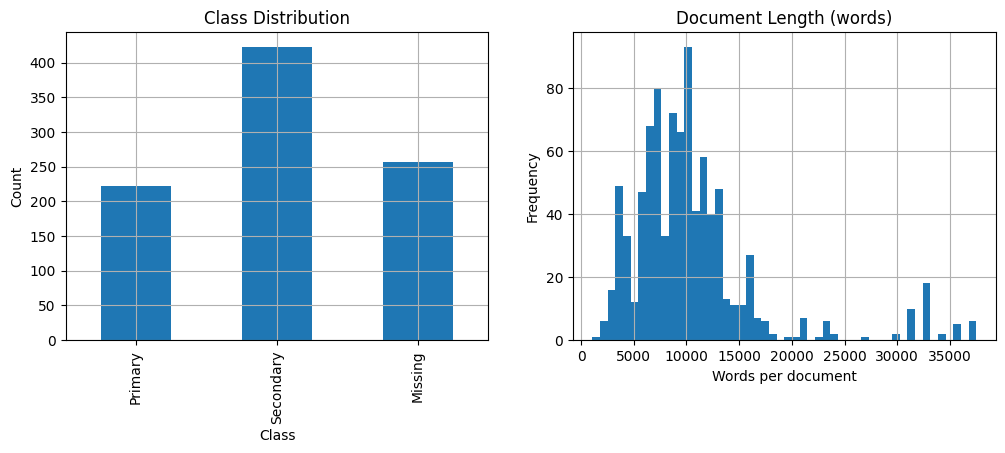

        char_len  word_len
count     902.00    902.00
mean    69688.25  10566.52
std     47968.31   6370.53
min      7073.00   1055.00
25%     45685.00   6748.00
50%     60076.00   9450.00
75%     78688.50  12047.00
max    372739.00  37506.00


In [5]:
# ============================================================
# Cell 4: Quick EDA (Class balance & text length)
# ============================================================
# Text length features
train["char_len"] = train["text"].str.len()
train["word_len"] = train["text"].str.split().map(len)

fig, ax = plt.subplots(1,2, figsize=(12,4))
# Class distribution
(train["y"].map(id2lab).value_counts()
 .reindex(["Primary","Secondary","Missing"])
 .plot(kind="bar", ax=ax[0], title="Class Distribution"))
ax[0].set_xlabel("Class"); ax[0].set_ylabel("Count")

# Document length
train["word_len"].plot(kind="hist", bins=50, ax=ax[1], title="Document Length (words)")
ax[1].set_xlabel("Words per document")
plt.show()

print(train[["char_len","word_len"]].describe().round(2))


In [6]:
# ============================================================
# Cell 5: Train/Validation Split
# ============================================================
trn, val = train_test_split(
    train[["article_id","dataset_id","text","y"]],
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=train["y"]
)
print(trn.shape, val.shape)


(721, 4) (181, 4)


TF-IDF shape (train): (902, 270000)


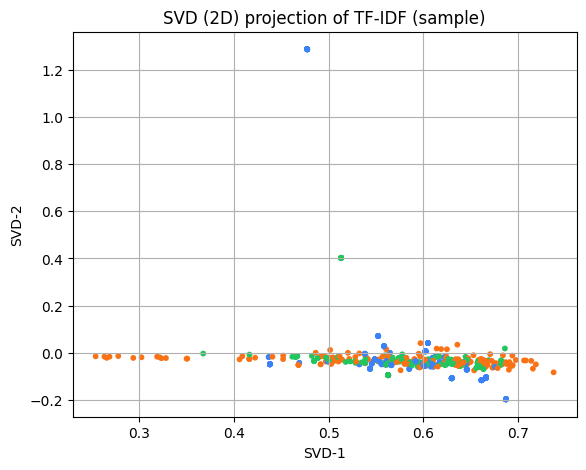

In [7]:
# ============================================================
# Cell 6: TF-IDF preprocess & 2D SVD visualization
# ============================================================
word_tfidf = TfidfVectorizer(
    analyzer="word", ngram_range=(1,2),
    min_df=2, max_features=120_000,
    stop_words="english", sublinear_tf=True
)
char_tfidf = TfidfVectorizer(
    analyzer="char", ngram_range=(3,5),
    min_df=2, max_features=150_000,
    sublinear_tf=True
)
preprocess = ColumnTransformer(
    [("w", word_tfidf, "text"),
     ("c", char_tfidf, "text")],
    remainder="drop", verbose_feature_names_out=False
)

# Fit on ALL train (for visualization only; does not affect eval pipelines)
X_all = preprocess.fit_transform(train)
print("TF-IDF shape (train):", X_all.shape)

# 2D SVD projection for visualization
svd_viz = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
X_2d = svd_viz.fit_transform(X_all)

# Sample for plot (to keep figure readable)
idx = np.random.RandomState(RANDOM_STATE).choice(len(train), size=min(600, len(train)), replace=False)
colors = np.array(["#22c55e", "#3b82f6", "#f97316"])  # Primary, Secondary, Missing
plt.figure(figsize=(6.5,5))
plt.scatter(X_2d[idx,0], X_2d[idx,1], s=10, c=colors[train["y"].values[idx]])
plt.title("SVD (2D) projection of TF-IDF (sample)")
plt.xlabel("SVD-1"); plt.ylabel("SVD-2")
plt.show()


In [8]:
# ============================================================
# Cell 7: Utilities — train/eval and model definitions
# ============================================================
def train_eval_supervised(model_name, model_pipeline):
    model_pipeline.fit(trn, trn["y"])
    pred = model_pipeline.predict(val)
    acc = accuracy_score(val["y"], pred)
    f1  = f1_score(val["y"], pred, average="macro")
    print(f"\n=== {model_name} ===")
    print(f"Accuracy (val): {acc:.4f} | Macro-F1 (val): {f1:.4f}")
    print(classification_report(val["y"], pred, target_names=["Primary","Secondary","Missing"]))
    # Confusion matrix
    cm = confusion_matrix(val["y"], pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(cm, display_labels=[id2lab[i] for i in [0,1,2]])
    plt.figure(figsize=(5,4))
    disp.plot(values_format='d')
    plt.title(f"{model_name} — Confusion Matrix")
    plt.show()
    return {"acc": acc, "f1": f1, "pipe": model_pipeline}

# Model definitions
svm_pipe = Pipeline([
    ("tfidf", preprocess),
    ("clf", LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM_STATE))
])

mlp_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE)),
    ("scale", StandardScaler(with_mean=True)),
    ("clf", MLPClassifier(hidden_layer_sizes=(256,),
                          activation="relu", solver="adam",
                          alpha=1e-4, batch_size=256, max_iter=15,
                          random_state=RANDOM_STATE, early_stopping=True))
])

dt_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE)),
    ("scale", StandardScaler(with_mean=True)),
    ("clf", DecisionTreeClassifier(max_depth=40,
                                   min_samples_split=5,
                                   min_samples_leaf=2,
                                   class_weight="balanced",
                                   random_state=RANDOM_STATE))
])

rf_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE)),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        class_weight="balanced_subsample", n_jobs=-1, random_state=RANDOM_STATE
    ))
])



=== Support Vector Machine (LinearSVC) ===
Accuracy (val): 0.9448 | Macro-F1 (val): 0.9413
              precision    recall  f1-score   support

     Primary       0.85      0.93      0.89        44
   Secondary       0.98      0.93      0.95        85
     Missing       0.98      0.98      0.98        52

    accuracy                           0.94       181
   macro avg       0.94      0.95      0.94       181
weighted avg       0.95      0.94      0.95       181



<Figure size 500x400 with 0 Axes>

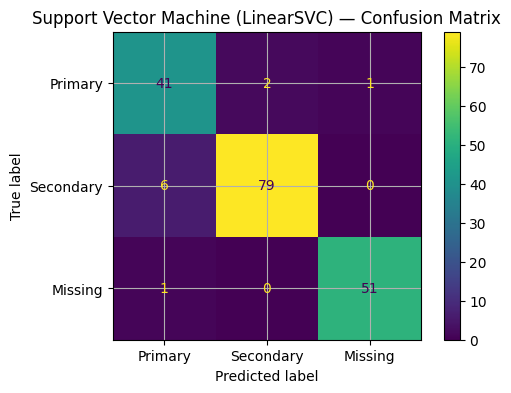

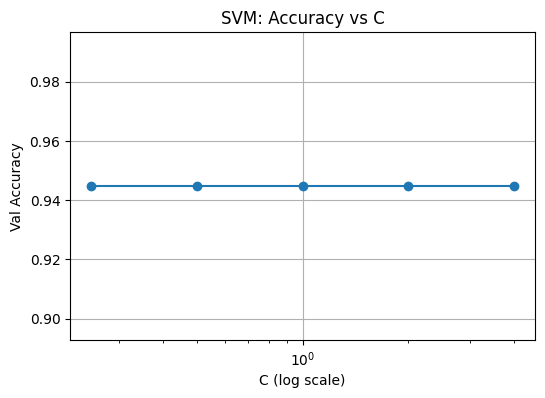

In [9]:
# ============================================================
# Cell 8: Train SVM + C sweep diagram
# ============================================================
results = {}
results["SVM"] = train_eval_supervised("Support Vector Machine (LinearSVC)", svm_pipe)

# Tiny hyperparam sweep for visualization (C vs Accuracy)
C_values = [0.25, 0.5, 1, 2, 4]
accs = []
for C in C_values:
    pipe_c = Pipeline([("tfidf", preprocess),
                       ("clf", LinearSVC(C=C, class_weight="balanced", random_state=RANDOM_STATE))])
    pipe_c.fit(trn, trn["y"])
    pred_c = pipe_c.predict(val)
    accs.append(accuracy_score(val["y"], pred_c))

plt.figure(figsize=(6,4))
plt.plot(C_values, accs, marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)"); plt.ylabel("Val Accuracy")
plt.title("SVM: Accuracy vs C")
plt.show()



=== Neural Network (MLP) ===
Accuracy (val): 0.8840 | Macro-F1 (val): 0.8708
              precision    recall  f1-score   support

     Primary       0.78      0.80      0.79        44
   Secondary       0.92      0.93      0.92        85
     Missing       0.92      0.88      0.90        52

    accuracy                           0.88       181
   macro avg       0.87      0.87      0.87       181
weighted avg       0.88      0.88      0.88       181



<Figure size 500x400 with 0 Axes>

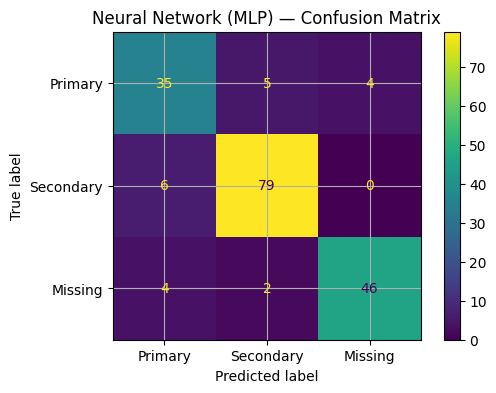

In [10]:
# ============================================================
# Cell 9: Train Neural Network (MLP)
# ============================================================
results["MLP"] = train_eval_supervised("Neural Network (MLP)", mlp_pipe)


In [ ]:
# ============================================================
# Cell 10: Train Decision Tree
# ============================================================
results["DecisionTree"] = train_eval_supervised("Decision Tree", dt_pipe)


In [ ]:
# ============================================================
# Cell 11: Train Random Forest
# ============================================================
results["RandomForest"] = train_eval_supervised("Random Forest", rf_pipe)


In [ ]:
# ============================================================
# Cell 12: Clustering (KMeans) + elbow/silhouette + confusion (mapped)
# ============================================================
# Reduce validation set for clustering/metrics
kmeans_pipe = Pipeline([
    ("tfidf", preprocess),
    ("svd", TruncatedSVD(n_components=256, random_state=RANDOM_STATE))
])
X_val_red = kmeans_pipe.fit_transform(val)

# Elbow (inertia) & silhouette across k
K = range(2, 7)
inertias, sils = [], []
for k in K:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels = km.fit_predict(X_val_red)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_val_red, labels))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(list(K), inertias, marker="o")
ax[0].set_title("KMeans Elbow (Inertia)")
ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")

ax[1].plot(list(K), sils, marker="o")
ax[1].set_title("KMeans Silhouette")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette Score")
plt.show()

# Fit with k=3 (classes) and evaluate vs ground truth
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=20)
clusters = kmeans.fit_predict(X_val_red)

def cluster_to_label_accuracy(y_true, y_pred, n_classes=3):
    cost = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(n_classes):
        for j in range(n_classes):
            cost[i, j] = -np.sum((y_true == i) & (y_pred == j))  # negative for maximization
    row_ind, col_ind = linear_sum_assignment(cost)
    mapping = {cluster: label for cluster, label in zip(col_ind, row_ind)}
    mapped = np.vectorize(mapping.get)(y_pred)
    acc = (mapped == y_true).mean()
    return acc, mapping, mapped

km_acc, km_map, km_pred_mapped = cluster_to_label_accuracy(val["y"].values, clusters, n_classes=3)
hom = homogeneity_score(val["y"], clusters)
com = completeness_score(val["y"], clusters)
vms = v_measure_score(val["y"], clusters)
ari = adjusted_rand_score(val["y"], clusters)

print(f"KMeans (k=3) — Cluster→Label acc (Hungarian): {km_acc:.4f}")
print(f"Homogeneity: {hom:.4f} | Completeness: {com:.4f} | V-measure: {vms:.4f} | ARI: {ari:.4f}")
print("Cluster→Label mapping:", km_map)

cm = confusion_matrix(val["y"], km_pred_mapped, labels=[0,1,2])
disp = ConfusionMatrixDisplay(cm, display_labels=[id2lab[i] for i in [0,1,2]])
plt.figure(figsize=(5,4))
disp.plot(values_format='d')
plt.title("KMeans (mapped) — Confusion Matrix")
plt.show()


In [ ]:
# ============================================================
# Cell 13: Select best supervised (by Accuracy) & save .pkl
# ============================================================
supervised = {k:v for k,v in results.items() if k in ["SVM","MLP","DecisionTree","RandomForest"]}
best_name, best_info = max(supervised.items(), key=lambda kv: kv[1]["acc"])
best_acc, best_f1 = best_info["acc"], best_info["f1"]
best_pipe = best_info["pipe"]

print(f"🏆 Highest validation ACCURACY: {best_name} | Acc={best_acc:.4f} | Macro-F1={best_f1:.4f}")
out_path = "/kaggle/working/best_model.pkl"
joblib.dump(best_pipe, out_path)
print(f"✅ Saved best supervised model to: {out_path}")


In [ ]:
# ============================================================
# Cell 14: Submission (optional) + summary plot
# ============================================================
MAKE_SUBMISSION = True
if MAKE_SUBMISSION:
    test_pred = best_pipe.predict(test)
    test_labels = [id2lab[int(i)] for i in test_pred]
    sub = test.copy()
    sub["type"] = test_labels
    sub[["article_id","dataset_id","type"]].to_csv("/kaggle/working/submission.csv", index=False)
    print("✅ Saved /kaggle/working/submission.csv")

# Summary table
summary = (
    pd.DataFrame({
        "Model": list(supervised.keys()),
        "Val_Accuracy": [supervised[m]["acc"] for m in supervised],
        "Val_MacroF1":  [supervised[m]["f1"]  for m in supervised],
    }).sort_values("Val_Accuracy", ascending=False).reset_index(drop=True)
)
display(summary)

# Bar chart of metrics
x = np.arange(len(summary))
w = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - w/2, summary["Val_Accuracy"], width=w, label="Accuracy")
plt.bar(x + w/2, summary["Val_MacroF1"], width=w, label="Macro-F1")
plt.xticks(x, summary["Model"])
plt.ylim(0, 1.0)
plt.title("Validation Metrics by Model")
plt.legend()
plt.show()
